In [1]:
import os
from typing import List, Optional
import fire
from llama import Llama, Dialog
import llama
from tabulate import tabulate

In [2]:
# Define major elements of Llama2 7b
os.environ['models_loc'] : str          =       'D:\GitHub repositories\llama\\'
os.environ['ckpt_dir']   : str          =       os.environ['models_loc'] + 'llama-2-7b-chat' 
os.environ['tokenizer_path'] : str      =       os.environ['models_loc'] + 'tokenizer.model'
os.environ['ckpt_dir_crmsc']   : str    =       os.environ['models_loc'] + 'llama-2-7b-chat_crmsc' 
os.environ['tokenizer_pathcrmsc'] : str =       os.environ['models_loc'] + 'tokenizer_crmsc.model'
os.environ['RANK']                      =       '0'
os.environ['WORLD_SIZE']                =       '1'
os.environ['MASTER_ADDR']               =       'localhost'
os.environ['MASTER_PORT']               =       '12355'
# Another type of initialization
# torch.distributed.init_process_group(
#     backend='nccl',
#     init_method='env://',
#     timeout=datetime.timedelta(0, 1800),
#     world_size=0,
#     rank=0,
#     store=None,
#     group_name=''
# )


In [3]:
# Main parameters of the model for further tuning
# for now, we leave some of them as default
temperature : float     =       0.6
top_p : float           =       0.9
max_seq_len : int       =       12000
max_batch_size : int    =       1 # 16
max_gen_len : Optional[int] =   None

In [4]:
# We are now Building a model, which takes a bit of time of course
generator = Llama.build(
    ckpt_dir=os.environ['ckpt_dir'],
    tokenizer_path=os.environ['tokenizer_path'],
    max_seq_len=max_seq_len,
    max_batch_size=max_batch_size,
    
)


> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loaded in 71.37 seconds


In [5]:
# Its time to print first results
def printastable( dialog_ : Dialog , lastchatonly : bool = False ) -> None:
    sc_results = list()
    for index , dialog in enumerate(dialog_):
        if not lastchatonly:
            for msg in dialog:
                sc_results.append( ( index , msg['role'].capitalize() , msg['content'].capitalize() ) )
        else:
            for msg in dialog[-2::]:
                sc_results.append( ( index , msg['role'].capitalize() , msg['content'].capitalize()  ) )
    print( tabulate( sc_results , headers=["Scenario" , "Role" , "Content"],tablefmt='rounded_grid' , maxcolwidths=[None,None,150]) )

In [6]:
# This function will append 'assistant' to the sequence of dialog, meaning that we are focusing on one instead of many ( there are alternative solutions however, but for now its convenient).
def Update( dialogs_ : list[Dialog], results_ ) -> None:
    for dialog , result in zip(dialogs_ , results_ ):
        assert result['generation']['role'] == "assistant"
        dialog.append(
                {
                    "role"      :   result['generation']['role'],
                    "content"   :   result['generation']['content'].capitalize()
                }
        )
# This function simply asks a question and return latest dialog and its result
# Unfortunately, due to the structure of generation function, a question must always be asked of all dialogs
def Ask( dialogs_ : list[Dialog] , question_ : str ) -> None:
    for dialog in dialogs_:
        assert dialog[-1]['role'] != "user" , f"ASK: {dialog[-1]['role']}"
        dialog.append(
                {
                "role"      :   "user",
                "content"   :   question_
                }
        )
    Update( dialogs_ , generator.chat_completion( dialogs_ , max_gen_len=max_gen_len , temperature=temperature , top_p=top_p ) )

## Scenario 2

On this scenario, we are assuming that this model is able to predict the price of Lithium Hydroxide CIF well, given the price data from 15th of September till last day of October. We want to see the model's reaction and capability towards this request. 

We know that for forecasting the price, several model, most of which are based on AI, could execute this purpose accurately. Here, we want to see how close the `prediction` is to the reality.
-   Will the model understand that no price is going to be published during weekends?
-   Will the model realize the fact that prediction requires additional data, other than of numerical? For instance, will model request to be fed about geopolitical, vendornames, or other parameters which contribute to making disruptions in the price?
( later objective )

Firstly, we focus on reading and plotting data for better demonstration. As this is just a sysnthetic test, we assume that no statistical analysis is required.

In [7]:
# Contract type : Month 2
data_path 	= 	r"Data/"
data_read   =   dict()

import openpyxl

workbook        =   openpyxl.load_workbook( filename= data_path + '/LME Lithium Hydroxide CIF.xlsx' , read_only=False ) # We are going to add our results to this file later
colnames        =   list()

for col in workbook.worksheets[0].columns:
    colnames.append( col[0].value )
    data_read[col[0].value] = [t.value for t in col[1:]]
print( colnames  )


['DATE', 'LME LI HYDROXIDE CIF (USD per tonne)']


In [8]:
print( tabulate( data_read , headers=colnames , tablefmt='rounded_grid' , numalign='center' , floatfmt='.3f') )

╭─────────────────────┬────────────────────────────────────────╮
│ DATE                │  LME LI HYDROXIDE CIF (USD per tonne)  │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-15 00:00:00 │               28523.810                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-18 00:00:00 │               28523.810                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-19 00:00:00 │               28523.810                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-20 00:00:00 │               28333.330                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-21 00:00:00 │               28166.670                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-22 00:00:00 │               28166.670                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-25 00:00:00 │  

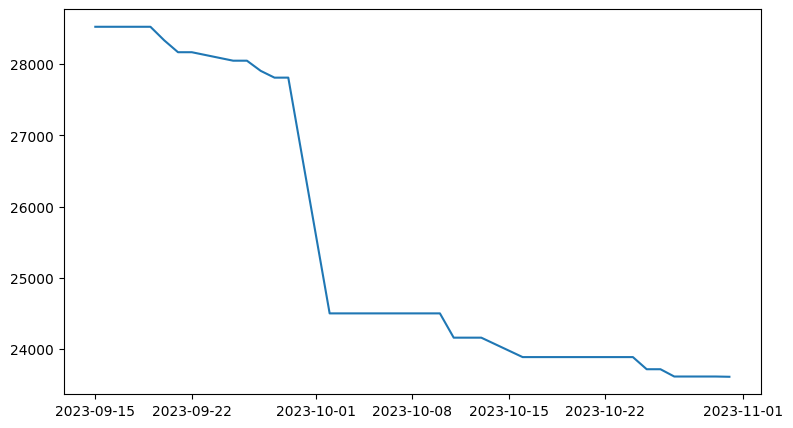

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig     =   plt.figure( figsize=(9,5) )
ax      =   fig.subplots(1,1)
ax.plot(data_read[colnames[0]],data_read[colnames[1]])

In [10]:
# Lets see if we can harness this dataset into our LLM model! 
# Notice that we assume no extra AI or ML model(s) will be used for prediction
SC2_Dialogs : list[ Dialog ]    =   [
    [
        {
            "role"      :   "system",
            "content"   :   """
We are going to simulate an environment at which the understanding of supply chain of Lithium Hydroxide and its disruptive events are important to us. Fundamentals events and assumptions of this environment are as follows:
-   There are 3 suppliers, namely 'A','B', and 'C'. Supplier A is located in country 'Z', while B and C are located in country 'T'. All of them are supplying Lithium Hydroxide.
-   Country Z holds 400 metrics tons of lithium ore as mineral reserves, while Country T has 300 metrics tons. Country 'Y' has 150 metrics tons but due to environmental issues, all extraction and refining projects has been suspended.
-   Each ton of lithium ore can be converted to lithium hydroxide by the ratio of 0.85. For example, if you have 3 tons of lithium ore, you would have 3 * 0.85 = 2.55 tons of lithium hydroxide after extraction and refining.
-   Remember that lithium ore is not as same as lithium hydroxide. Do not confuse these two commodities with each other.
-   We have two consumers, namely 'D' and 'E'. Consumer 'D' is located in country 'T', purchasing the aforementioned commodity from vendor A and B. Contrary to this, consumer 'E' is located in country 'Y' and purchases only from supplier 'C'. Consequently, supplier 'A' and consumer 'E' are alone in their countries.
-   A can deliver 10 tons within 6 days to D.
-   B can deliver 5 tons within 8 days to D.
-   C can deliver 5 tons within 5 days to E.
Notice that whenever you are asked about production concentration, you need to calculate a parameter called Herfindahl-Hirschmann Index, or HHI. for calculating HHI, follow these steps:
-   Find the reserve of every country and sum all of them. This will be the total amount. Then, divide each country reserve by the total amount to calculate relative share of every country, called s.
-   Power all s values to the power of 2.
-   Sum all s^2 values to calculate HHI, and check whether it lies between 0 and 1.
    """
        }
    ]
]

In [11]:
SC2Q1   =   "Can you summarize the environment you have already been notified recently?"
Ask( SC2_Dialogs , SC2Q1 )

In [12]:
printastable( SC2_Dialogs )

╭────────────┬───────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ System    │ we are going to simulate an environment at which the understanding of supply chain of lithium hydroxide and its disruptive events are important to     │
│            │           │ us. fundamentals events and assumptions of this environment are as follows: -   there are 3 suppliers, namely 'a','b', and 'c'. supplier a is located  │
│            │           │ in country 'z', while b and c are located in country 't'. all of them are

In [13]:
SC2Q2   =  "Can you rewrite the assumption of a environment I have told you already in a sequence?" 
Ask( SC2_Dialogs , SC2Q2 )

In [14]:
printastable( SC2_Dialogs , True )

╭────────────┬───────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ Can you rewrite the assumption of a environment i have told you already in a sequence?                                                                 │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ Assistant │ of course! here are the assumptions you provided in a sequence: 1. there 

In [15]:
# Seems fine... but the model still did not understand the relationships between sectors
SC2Q3   =  "You did it fine, but tell me more specifically about suppliers and consumers. From which vendor(s) and how much do the consumers buy lithium hydroxide? \
            Please format the output as table like <NAME> located in Country <COUNTRY> stands as Supplier/Consumer selling/buying <AMOUNT> within <DAYS>"
Ask( SC2_Dialogs , SC2Q3 )


In [16]:
printastable( SC2_Dialogs , True )

╭────────────┬───────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                               │
├────────────┼───────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ You did it fine, but tell me more specifically about suppliers and consumers. from which vendor(s) and how much do the consumers buy lithium          │
│            │           │ hydroxide?             please format the output as table like <name> located in country <country> stands as supplier/consumer selling/buying <amount> │
│            │           │ within <days>                                                                 

In [17]:
Ask( SC2_Dialogs , "Good, but a small mistake you made. Consumer d purchases a total amount of 15 from a and b. Also, consumer E purchases 5 tons instead of 2 tons from supllier C. Please, rewrite your last response to be checked.")

In [18]:
printastable( SC2_Dialogs , True )

╭────────────┬───────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                               │
├────────────┼───────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ Good, but a small mistake you made. consumer d purchases a total amount of 15 from a and b. also, consumer e purchases 5 tons instead of 2 tons from  │
│            │           │ supllier c. please, rewrite your last response to be checked.                                                                                         │
├────────────┼───────────┼───────────────────────────────────────────────────────────────────────────────

In [19]:
Ask( SC2_Dialogs , "Great, can you tell me the HHI of lithium ore inside this environment?" )

In [20]:
printastable( SC2_Dialogs , True )

╭────────────┬───────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ Great, can you tell me the hhi of lithium ore inside this environment?                                                                                 │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ Assistant │ yes, to calculate the herfindahl-hirschman index (hhi) of lithium ore ins

In [21]:
# Such a nice answer, but the definition of HHI is not defined well, as the model missed country Y
Ask( SC2_Dialogs ,  "Well, few mistakes you made. First, country T has 300 tons of lithium ore and not 250! Second, you missed country Y in your calculation. Please revise your answer.Notice that the main concept you pursued for HHI is right." )

In [22]:
printastable( SC2_Dialogs , True )

╭────────────┬───────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ Well, few mistakes you made. first, country t has 300 tons of lithium ore and not 250! second, you missed country y in your calculation. please revise │
│            │           │ your answer.notice that the main concept you pursued for hhi is right.                                                                                 │
├────────────┼───────────┼──────────────────────────────────────────────────────────────────────────

In [23]:
# Seems the model mixed up numbers, we need to rephrase it more accurately
Ask( SC2_Dialogs , "Well, again you made a mistake, and that is country Z has 400 tons, not 200 tons! the rest of calculation is fine. Please revise your answer." )

In [24]:
printastable( SC2_Dialogs , True )

╭────────────┬───────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ Well, again you made a mistake, and that is country z has 400 tons, not 200 tons! the rest of calculation is fine. please revise your answer.          │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ Assistant │ my apologies, you are correct. thank you for pointing out the mistake. he

In [25]:
# This time the model calculates successfully ( After many attemps, roughly has been taken for a month or two).
Ask( SC2_Dialogs , "Well done, can you depict the relationships between suppliers and consumers within a graph?" )

In [26]:
printastable( SC2_Dialogs , True )

╭────────────┬───────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ Well done, can you depict the relationships between suppliers and consumers within a graph?                                                            │
├────────────┼───────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ Assistant │ yes, i can definitely help you depict the relationships between suppliers

In [ ]:
# Mistakes again have been made, as the model is not trained well